$$A \rightleftharpoons 2B + C$$

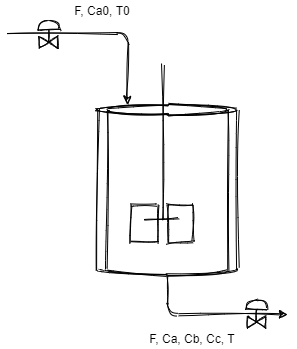

$$ {dC_A \over dt} = {F \over V}(C{A_0} - C_A) - C_A k_0 e^{-E/RT} $$  
$$ {dC_B \over dt} = -{F \over V} C_B + 2 C_A k_0 e^{-E/RT} $$  
$$ {dC_C \over dt} = -{F \over V} C_C + C_A k_0 e^{-E/RT} $$  
$$ {dT \over dt} = {F \over V}(T_0 - T) - {C_A \Delta H k_0 e^{-E/RT} \over \rho Cp} $$

In [462]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [570]:
#parâmetros

Ea = 48500 # J/mol
R = 8.314 # J/mol/K
deltaH = -72800 # J/mol
cp = 1750 # J/kg K
rho = 880 # kg/m³
k0 = 8.2e7 #/min
k0 = k0*60 #/h
V = 50 #m³

#variáveis

F = lambda t: 10 + 10*np.sin(np.pi*t/3) # m³/h
T0 = lambda t: 300 + 100*t**0.2 if t<5 else 300 + 100*5**0.2 # K
Ca0 = lambda t: 100/(t+1)**(0.5) # mol/m³
Cb0 = lambda t: 0
Cc0 = lambda t: 0

In [573]:
def k(T):
    return k0*np.exp(-Ea/R/T)

def dcidt(composto, Ca, Ci, T, t): #construtor de balanço de massa
    if composto == 'a':
        return F(t)/V *(Ca0(t)-Ci) - k(T)*Ca
    elif composto == 'b':
        return F(t)/V *(Cb0(t)-Ci) + 2*k(T)*Ca
    else:
        return F(t)/V *(Cc0(t)-Ci) + k(T)*Ca

def ODEs(p, t):
    Ca, Cb, Cc, T = p
    dcadt =  dcidt('a', Ca, Ca, T, t) #equações do BM de a, b e c.
    dcbdt =  dcidt('b', Ca, Cb, T, t) #não é a maneira mais elegante de se fazer o BM, mas o torna mais claro.
    dccdt =  dcidt('c', Ca, Cc, T, t) 
    dTdt = - Ca*k(T)*deltaH/rho/cp + F(t)/V *(T0(t)-T) #BE
    
    return [dcadt, dcbdt, dccdt, dTdt]

contorno = [Ca0(0), Cb0(0), Cc0(0), T0(0)] #condições iniciais para as variáveis resposta

t = np.linspace(0, 30, 10000)
Cas = odeint(ODEs, contorno, t)[:,0] #Ca(t)
Cbs = odeint(ODEs, contorno, t)[:,1] #Cb(t)
Ccs = odeint(ODEs, contorno, t)[:,2] #Cc(t)
Ts = odeint(ODEs, contorno, t)[:,3] #T(t)

T0s = list(map(T0, t)) #Tentrada(t)
Fs = list(map(F, t)) #F(t)
Ca0s = list(map(Ca0, t)) #Ca entrada(t)

Text(0, 0.5, 'temperatura (K)')

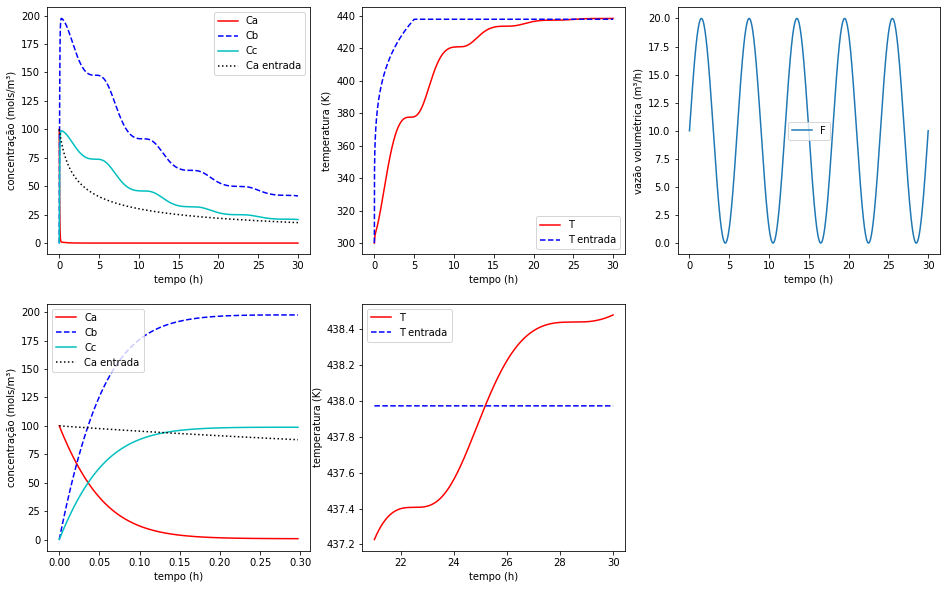

In [581]:
figura = plt.figure(figsize = (16, 10))

grafico1 = figura.add_subplot(2, 3, 1) #plot do gráfico 'composições x tempo'
grafico1.plot(t, Cas, 'r')
grafico1.plot(t, Cbs, 'b--')
grafico1.plot(t, Ccs, 'c')
grafico1.plot(t, Ca0s, 'k:')
grafico1.legend(['Ca', 'Cb', 'Cc', 'Ca entrada'], loc = 'best')
grafico1.set_xlabel('tempo (h)')
grafico1.set_ylabel('concentração (mols/m³)')

grafico2 = figura.add_subplot(2, 3, 2) #plot do gráfico 'temperatura x tempo'
grafico2.plot(t, Ts, 'r')
grafico2.plot(t, T0s, 'b--')
grafico2.legend(['T', 'T entrada'])
grafico2.set_xlabel('tempo (h)')
grafico2.set_ylabel('temperatura (K)')

grafico3 = figura.add_subplot(2, 3, 3) #plot do gráfico 'vazão x tempo'
grafico3.plot(t, Fs)
grafico3.legend(['F'])
grafico3.set_xlabel('tempo (h)')
grafico3.set_ylabel('vazão volumétrica (m³/h)')

grafico4 = figura.add_subplot(2, 3, 4) #zoom plot do gráfico 'composições x tempo' nos primeiros 30 minutos
grafico4.plot(t[:100], Cas[:100], 'r')
grafico4.plot(t[:100], Cbs[:100], 'b--')
grafico4.plot(t[:100], Ccs[:100], 'c')
grafico4.plot(t[:100], Ca0s[:100], 'k:')
grafico4.legend(['Ca', 'Cb', 'Cc', 'Ca entrada'], loc = 'best')
grafico4.set_xlabel('tempo (h)')
grafico4.set_ylabel('concentração (mols/m³)')

grafico5 = figura.add_subplot(2, 3, 5) #zoom do plot do gráfico 'temperatura x tempo para as últimas 10 horas'
grafico5.plot(t[-3000:-1], Ts[-3000:-1], 'r')
grafico5.plot(t[-3000:-1], T0s[-3000:-1], 'b--')
grafico5.legend(['T', 'T entrada'])
grafico5.set_xlabel('tempo (h)')
grafico5.set_ylabel('temperatura (K)')

Apesar de calor ser gerado dentro do reator, T saída < T entrada porque a curva de aumento de temperatura do que entra supera o calor gerado dentro do reator *(observe o gráfico 2)*. Nessa defasagem entre a corrente com uma T(t-i) e a nova corrente com T(t), se T(t) > T(t-i) + Qreação, então T entrada > T saída para um determinado instante de tempo, porque o que sai num momento t está relacionado com o que entrou em t-i e não em t.

Isso pode ser verificado quando observamos T entrada estabilizar. Nesse momento, T saída o alcança, até ligeiramente passá-lo. *(Observe o gráfico 5)*